This Notebook is dedicated for the research on MRI Domain adaptation project

In [1]:
import torch

In [2]:
print("h")

h


In [3]:
import logging
import pathlib
import random
import shutil
import time
import os
import sys

import numpy as np
import torch
import torchvision
from tensorboardX import SummaryWriter
from torch.nn import functional as F
from torch.utils.data import DataLoader
from common.args import Args
from data import transforms2
import matplotlib

In [4]:
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from models.subsampling_model import Subsampling_Model
from scipy.spatial import distance_matrix
import scipy.io as sio
from common.utils import get_vel_acc
#from common.evaluate import psnr, ssim
from fastmri.losses import SSIMLoss
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt

/home/mohammedw/miniconda3/envs/mpilot-py310/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mohammedw/miniconda3/envs/mpilot-py310/lib/python3.12/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/mohammedw/miniconda3/envs/mpilot-py310/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
import torch
from torch import nn
from torch.nn import functional as F

import fastmri.models
from models.rec_models.unet_model import UnetModel
from models.rec_models.complex_unet import ComplexUnetModel
import data.transforms2 as transforms
from pytorch_nufft.nufft2 import nufft, nufft_adjoint
import numpy as np
from WaveformProjection.run_projection import proj_handler
import matplotlib.pylab as P
from models.rec_models.vision_transformer import VisionTransformer
from models.rec_models.recon_net import ReconNet
from models.rec_models.humus_net import HUMUSNet, HUMUSBlock
from  models.VarBlock import VarNet
from typing import Tuple
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import apply_mask

import torch
import numpy as np

In [6]:
print("h")

h


In [7]:
from torch.optim import SGD
import torch
import torch.nn.functional as F

def pgd_attack_with_trajectory(model, input_tensor, target_tensor, epsilon, alpha=0.1, steps=10, norm='linf'):
    """
    PGD attack with support for L1, L2, and Linf norms
    Args:
        model: Model to attack
        input_tensor: Clean input tensor
        target_tensor: Ground truth target
        epsilon: Attack strength
        alpha: Attack step size
        steps: Number of PGD steps
        norm: Norm to use for projection ('l1', 'l2', or 'linf')
    """
    device = torch.device(f'cuda:{model.device_ids[0]}')
    model = model.to(device)
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)
    
    alpha = epsilon/steps
    # Initialize perturbation
    #print("Initial requires_grad:", model.module.subsampling.x.requires_grad)  # Output: False
    original_trajectory = model.module.subsampling.x.detach().clone()
    perturbation = torch.zeros_like(original_trajectory, requires_grad=True).to(device)
    model.module.subsampling.x.requires_grad_(True)
    #print("Updated requires_grad:", model.module.subsampling.x.requires_grad)  # Output: True
    
    lowest_psnr = float('inf')
    best_perturbation = torch.zeros_like(perturbation)
    
    for _ in range(steps):
        # Apply perturbation
        perturbed_trajectory = original_trajectory + perturbation
        perturbed_trajectory = torch.clamp(perturbed_trajectory, min=-160, max=160)
        
        # Zero gradients
        if model.module.subsampling.x.grad is not None:
            model.module.subsampling.x.grad.zero_()
        
        # Forward pass
        model.module.subsampling.x.data = perturbed_trajectory
        output = model(input_tensor.unsqueeze(1))
        target = target_tensor.view_as(output) if output.shape != target_tensor.shape else target_tensor

        # Calculate loss and PSNR
        loss = F.l1_loss(output.to(device), target.to(device))
        current_psnr = psnr(target.detach().cpu().numpy(), 
                          output.detach().cpu().numpy())

        # Track best attack
        if current_psnr < lowest_psnr:
            lowest_psnr = current_psnr
            best_perturbation = perturbation.detach().clone()

        # Backward pass
        loss.backward()
        
        # Update perturbation based on norm
        if norm == 'linf':
            # Linf: sign of gradient
            if model.module.subsampling.x.grad != None:
                perturbation.data = perturbation.data + alpha * model.module.subsampling.x.grad.sign()
            else:
                 perturbation.data = perturbation.data
            perturbation.data = torch.clamp(perturbation.data, -epsilon, epsilon)
        elif norm == 'l2':
            # L2: normalized gradient
            grad = model.module.subsampling.x.grad
            l2_norm = torch.norm(grad.view(grad.shape[0], -1), p=2, dim=1)
            normalized_grad = grad / (l2_norm.view(-1, 1, 1) + 1e-10)
            perturbation.data = perturbation.data + alpha * normalized_grad
            perturbation.data = project_l2(perturbation.data, epsilon)
        elif norm == 'l1':
            # L1: coordinate-wise update
            grad = model.module.subsampling.x.grad
            perturbation.data = perturbation.data + alpha * grad.sign()
            perturbation.data = project_l1(perturbation.data, epsilon)
        else:
            raise ValueError(f"Unsupported norm: {norm}")
    
    # Restore original trajectory
    model.module.subsampling.x.data = original_trajectory.data
    return best_perturbation, lowest_psnr

# Projection functions (same as provided)
def project_linf(perturbation, epsilon):
    return torch.clamp(perturbation, -epsilon, epsilon)

def project_l2(perturbation, epsilon):
    flat = perturbation.view(perturbation.shape[0], -1)
    norm = flat.norm(p=2, dim=1, keepdim=True)
    factor = torch.min(torch.ones_like(norm), epsilon / (norm + 1e-10))
    projected = flat * factor
    return projected.view_as(perturbation)

def project_l1(perturbation, epsilon):
    original_shape = perturbation.shape
    x_flat = perturbation.view(perturbation.shape[0], -1)
    abs_x = torch.abs(x_flat)

    sorted_x, _ = torch.sort(abs_x, descending=True, dim=1)
    cumsum = torch.cumsum(sorted_x, dim=1)

    rho = (sorted_x * torch.arange(1, x_flat.shape[1] + 1, device=x_flat.device)) > (cumsum - epsilon)
    rho_idx = rho.sum(dim=1) - 1
    theta = (cumsum.gather(1, rho_idx.unsqueeze(1)) - epsilon) / (rho_idx + 1).float().unsqueeze(1)
    theta = torch.clamp(theta, min=0)

    projected = torch.sign(x_flat) * torch.clamp(abs_x - theta, min=0)
    return projected.view(original_shape)

In [8]:
def visualize_attack_on_models(model_dict, input_img, target_img, epsilon=3):
    """
    For each model in the dictionary, show prediction before and after PGD attack on the trajectory.
    
    Parameters:
    - model_dict: dict of {name: model}
    - input_img: tensor, shape [1, H, W] or [H, W] (will be unsqueezed)
    - target_img: ground truth (used for attack)
    - epsilon: perturbation bound for PGD attack
    """
    import matplotlib.pyplot as plt
    
    for name, model in model_dict.items():
        print(f"--- {name} ---")
        
        # Show prediction before attack
        print("Clean prediction:")
        clean_image = model(input_img.unsqueeze(1))
        show_image(clean_image[0])
        
        # Apply PGD attack on trajectory
        delta_traj = pgd_attack_with_trajectory(model, input_img, target_img, epsilon)[0]
        model.module.get_trajectory().data += delta_traj
        
        # Show prediction after attack
        print("After PGD attack on trajectory:")
        attacked_image = model(input_img.unsqueeze(1))
        show_image(attacked_image[0])
        
        # Optionally, plot both side by side
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(clean_image.detach().cpu().squeeze(), cmap='gray')
        axs[0].set_title(f"{name} - Clean")
        axs[0].axis('off')
        
        axs[1].imshow(attacked_image.detach().cpu().squeeze(), cmap='gray')
        axs[1].set_title(f"{name} - After Attack")
        axs[1].axis('off')
        plt.show()

In [9]:
def visualize_trajectory_noise_effects(model_dict, input_img, std_list=[25, 50, 75, 100], clip_range=(-160, 160)):
    """
    For each model, shows predictions with clean and noisy trajectories.

    Parameters:
    - model_dict: dict of {name: model}
    - input_img: torch.Tensor, shape [1, H, W]
    - std_list: list of std values for Gaussian noise
    - clip_range: tuple (min, max) for trajectory clipping
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    for name, model in model_dict.items():
        print(f"=== {name} ===")
        model.eval()

        # Get base trajectory
        base_traj = model.module.get_trajectory().data.clone().cpu().numpy()

        # Store all reconstructions: (title, image)
        reconstructions = []

        # 1. Clean prediction
        model.module.get_trajectory().data = torch.tensor(base_traj, dtype=torch.float32).to(model.module.get_trajectory().device)
        clean_pred = model(input_img.unsqueeze(1)).detach().cpu()
        print(f"Clean prediction shape: {clean_pred.shape}")

        # Ensure 2D shape [H, W]
        clean_pred = torch.squeeze(clean_pred)  # Remove all singleton dimensions
        if clean_pred.ndim == 3:
            clean_pred = clean_pred[0]  # Select first channel if necessary
        elif clean_pred.ndim != 2:
            raise ValueError(f"Unexpected clean_pred shape: {clean_pred.shape}. Expected 2D array.")

        reconstructions.append(("Clean", clean_pred))

        # 2-5. Predictions with noisy trajectories
        for std in std_list:
            noise = np.random.normal(loc=0.0, scale=std, size=base_traj.shape)
            noisy_traj = np.clip(base_traj + noise, clip_range[0], clip_range[1]).astype(np.float32)

            model.module.get_trajectory().data = torch.tensor(noisy_traj, dtype=torch.float32).to(model.module.get_trajectory().device)
            noisy_pred = model(input_img.unsqueeze(1)).detach().cpu()
            print(f"Noisy prediction shape (std={std}): {noisy_pred.shape}")

            # Ensure 2D shape [H, W]
            noisy_pred = torch.squeeze(noisy_pred)  # Remove all singleton dimensions
            if noisy_pred.ndim == 3:
                noisy_pred = noisy_pred[0]  # Select first channel if necessary
            elif noisy_pred.ndim != 2:
                raise ValueError(f"Unexpected noisy_pred shape: {noisy_pred.shape}. Expected 2D array.")

            reconstructions.append((f"STD={std}", noisy_pred))

        # Plotting
        fig, axs = plt.subplots(1, len(reconstructions), figsize=(4 * len(reconstructions), 4))
        if len(reconstructions) == 1:
            axs = [axs]  # Make iterable if only one subplot

        for ax, (title, img) in zip(axs, reconstructions):
            ax.imshow(img.numpy(), cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        fig.suptitle(f"Model: {name}", fontsize=16)
        plt.tight_layout()
        plt.show()

In [10]:
def train_epoch(args, model, data_loader, optimizer):
    model.train()
    avg_loss = 0.

    psnr_l = []
    ssim_l = []
    start_epoch = start_iter = time.perf_counter()
    print(f'a_max={args.a_max}, v_max={args.v_max}')

    for iter, data in enumerate(data_loader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()

        input, target, mean, std, norm = data
        if input is None:
            print("skipping")
            continue

        noise = torch.zeros_like(input)
        if args.noise_behaviour == "image" and random.random() <= (1 - args.noise_p):
            print("applied!")
            noise = torch.randn_like(input) * args.std

        input = input + noise
        input = input.to(args.device)
        target = target.to(args.device)


        output = model(input.unsqueeze(1))
        x = model.module.get_trajectory()
        v, a = get_vel_acc(x)
        acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, args.a_max).abs() + 1e-8, 2)))
        vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, args.v_max).abs() + 1e-8, 2)))
        resolution = target.shape[-1]

        data_min = target.min()
        data_max = target.max()
        target_normalized = (target - data_min) / (data_max - data_min)
        output_normalized = (output - data_min) / (data_max - data_min)

        loss_l1 = F.l1_loss(output, target)
        psnr_l.append(psnr(target.detach().cpu().numpy(), output.detach().cpu().numpy()))
        ssim_l.append(ssim(target.detach().cpu().numpy(), output.detach().cpu().numpy()))
        rec_loss = loss_l1 #+ dcLoss # SSIMLoss().to(args.device)(output, target, data_range) # F.l1_loss(output, target)
        if args.TSP and epoch < args.TSP_epoch:
            loss = args.rec_weight * rec_loss
        else:
            loss = args.rec_weight * rec_loss + args.vel_weight * vel_loss + args.acc_weight * acc_loss

        #if vel_loss + acc_loss > 1e-3:
        #    optimize_trajectory(args, model)

        #print("before backprop:", model.module.subsampling.x)
        loss.backward()
        #print("after backprop:", model.module.subsampling.x)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1.)
        optimizer.step()
        model.module.subsampling.attack_trajectory = None

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        # writer.add_scalar('TrainLoss', loss.item(), global_step + iter)

        if iter % args.report_interval == 0:
            logging.info(
                f'Iter = [{iter:4d}/{len(data_loader):4d}] '
                f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} '
                f'rec_loss: {rec_loss:.4g}, vel_loss: {vel_loss:.4g}, acc_loss: {acc_loss:.4g}'
                f'PSNR: {np.mean(psnr_l):.2f} +- {np.std(psnr_l):.2f}, SSIM: {np.mean(ssim_l):.4f} +- {np.std(ssim_l):.4f}'
            )
        start_iter = time.perf_counter()
    return avg_loss, time.perf_counter() - start_epoch

In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from torchvision.transforms import Resize, ToPILImage

def show_image(source):
    source = source.clone()
    source.reshape(320,320)
    image = source
    image -= image.min()
    max_val = image.max()
    if max_val > 0:
        image /= max_val
    source = image
    grid = torchvision.utils.make_grid(source, nrow=4, pad_value=1)
    numpy_image = grid.permute(1, 2, 0).cpu().detach().numpy()

    # Save or display the image
    plt.imshow(numpy_image)
    plt.axis('off')
    plt.show()

In [12]:
import torch
def show_trajectory_with_noise(model, std_list=[100]):
    """
    Displays the original trajectory from the model and additional trajectories
    with Gaussian noise added using different standard deviations.
    
    Args:
        model: A PyTorch model with `module.get_trajectory()` method.
        std_list: A list of standard deviation values to use for Gaussian noise.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract base trajectory
    base_traj = model.module.get_trajectory().detach().cpu().numpy()

    # Set up the plot
    plt.figure(figsize=(8, 8))
    
    # Plot base trajectory
    #plot_trajectory(base_traj)

    # Plot noisy trajectories
    for std in std_list:
        noise = np.random.normal(loc=0.0, scale=std, size=base_traj.shape)
        noisy_traj = base_traj + noise
        noisy_traj = np.clip(noisy_traj, -160, 160)
        plot_trajectory(noisy_traj)
        plt.show()

    plt.title("Trajectories with Different Gaussian Noise Levels")
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()


In [13]:
def plot_trajectory(x):
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    ax.axis([-165, 165, -165, 165])
    for i in range(x.shape[0]):
        ax.plot(x[i, :, 0], x[i, :, 1])
    return fig

def show_trajectory(model):
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt

    x = model.module.get_trajectory()
    fig = plot_trajectory(x.detach().cpu().numpy())
    plt.show()

In [14]:
def get_first_batch(dataloader):
    """
    Get the first example from the DataLoader without iteration.

    Args:
    - dataloader: PyTorch DataLoader object

    Returns:
    - first_input: The first input example in the dataset.
    - first_label: The label for the first input example.
    """
    inputs, labels, _, _, _ = next(iter(dataloader))
    first_input = inputs
    first_target = labels
    
    return first_input, first_target

In [15]:
import torch
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA device not available")

CUDA Device Name: NVIDIA RTX A6000


The `%matplotlib inline` option is needed to plot graphs in jupyter

In [16]:
%matplotlib inline

In [17]:
torch.cuda.empty_cache()

In [18]:
"""
Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import numpy as np
import torch


class TrajectoryFunc:
    def __init__(self, center_fractions, accelerations):
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()
        
        
    def mask_to_trajectory(self, mask):
        mask = np.squeeze(mask)

        x_values = [x for x in range(-160, 160)]

        trajectory = []
        for i in range(mask.shape[0]):
            #print(mask[i].item())
            if mask[i].item() == 1:
                for x in x_values:
                    trajectory.append([x, i - 160])
        return trajectory


    def __call__(self, shape, seed=None):
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Desired number of total columns to retain
        num_low_freqs = int(round(num_cols * center_fraction))
        num_total_samples = int(round(num_cols / acceleration))
        num_high_freqs = num_total_samples - num_low_freqs
        
        # Generate mask with zeros
        mask = np.zeros(num_cols, dtype=np.float32)

        # Always keep low-frequency columns in the center
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = 1

        # Randomly choose high-frequency indices outside the low-freq region
        low_freq_start = pad
        low_freq_end = pad + num_low_freqs
        available_indices = list(range(0, low_freq_start)) + list(range(low_freq_end, num_cols))
        
        if num_high_freqs > len(available_indices):
            raise ValueError("Not enough columns to sample from.")

        high_freq_indices = self.rng.choice(available_indices, size=num_high_freqs, replace=False)
        mask[high_freq_indices] = 1

        # Reshape mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape))
        return torch.tensor(self.mask_to_trajectory(mask)).reshape(int(round(num_cols / acceleration)),-1,2)
        


In [19]:
trajectoryFunc = TrajectoryFunc([0.0325], [10])
trajectory = trajectoryFunc([32, 320, 320])

In [20]:
trajectory.shape

torch.Size([32, 320, 2])

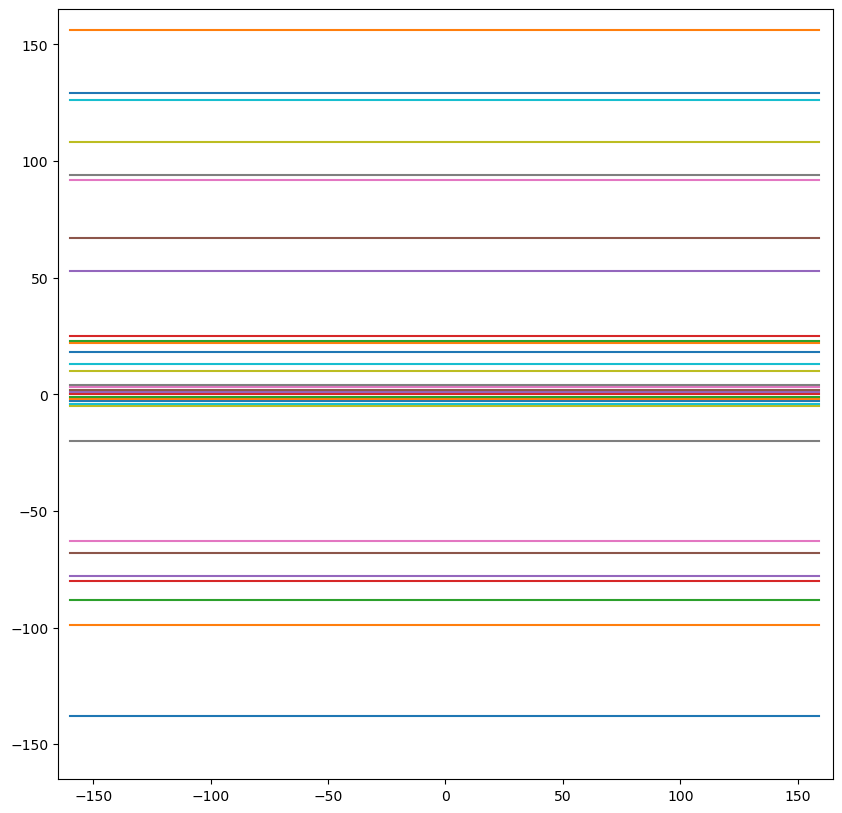

In [21]:
plot_trajectory(trajectory)

### SliceData
* Responsible of defining how we will read the data from the .h5 files

In [22]:
import pathlib
import random
import h5py
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision
import os
import torch

class SliceData(Dataset):
    def __init__(self, root, transform, challenge="multicoil", sample_rate=1, resolution=(320, 320)):
        assert challenge in ["singlecoil", "multicoil"], "Challenge must be 'singlecoil' or 'multicoil'"
        self.transform = transform
        self.challenge = challenge
        self.examples = []

        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]

        for fname in sorted(files):
            try:
                with h5py.File(fname, 'r') as data:
                    if "kspace" not in data:
                        continue  # Skip files without k-space data
                    
                    kspace = data["kspace"]
                    if self.challenge == "multicoil":
                        if len(kspace.shape) != 4:  # Ensure it follows (num_slices, num_coils, height, width)
                            continue
                    else:
                        if len(kspace.shape) != 3:  # Ensure it follows (num_slices, height, width)
                            continue
                    
                    num_slices = kspace.shape[0]
                    temp = [(fname, slice) for slice in range(5, num_slices - 2)]
                    for (fname, slice) in temp: 
                        try:
                            with h5py.File(fname, 'r') as data:
                                kspace = data["kspace"][slice]
                                if "reconstruction_rss" in data:
                                    try:
                                        target = data["reconstruction_rss"][slice]
                                        self.transform(kspace, target, data.attrs, fname.name, slice, self.challenge)
                                        self.examples.append((fname, slice))
                                    except Exception as e:
                                        print(e)
                                        continue
                                else:
                                    continue
                        except Exception as e:
                            print(e)
                            continue
                    print(len(self.examples))
            except Exception as e:
                print(e)
                continue
            
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        fname, slice = self.examples[i]
        try:
            with h5py.File(fname, 'r') as data:
                kspace = data["kspace"][slice]                
                if "reconstruction_rss" in data:
                    try:
                        target = data["reconstruction_rss"][slice]
                    except Exception as e:
                        print(e)
                        return None  
                else:
                    target = None
                return self.transform(kspace, target, data.attrs, fname.name, slice, self.challenge)
        except Exception as e:
            print(e)
            return None

### DataTransform
Resposible for preparing the data to be in the shape the model expects

### create_YYY_dataset
Creates the YYY dataset

### create_data_loaders
Creates the data loaders

In [23]:
import torch.nn.functional as F
import torch
from torchvision import transforms as visonTransforms
from PIL import Image
import torch.nn.functional as F


class DataTransform:
    def __init__(self, resolution):
        self.resolution = resolution
        self.resize_transform = visonTransforms.Resize((self.resolution, self.resolution)) 

    def __call__(self, kspace, target, attrs, fname, slice, challange="multicoil"):
        kspace = transforms.to_tensor(kspace)
        image = transforms.ifft2_regular(kspace)
        # Convert from two channels to complex
        if len(image.shape) == 4:
            image = image.permute(0, 3, 1, 2)
            if image.shape[-2] < self.resolution or image.shape[-1] < self.resolution:
                    image = F.interpolate(image, size=(self.resolution, self.resolution), mode='bilinear', align_corners=False)
            image = image.permute(0, 2, 3, 1)
        
        image = transforms.complex_center_crop(image, (self.resolution, self.resolution))
        image, mean, std = transforms.normalize_instance(image, eps=1e-11)
        
        #print(image.shape)
        target = transforms.to_tensor(target)
        target, mean, std = transforms.normalize_instance(target, eps=1e-11)
        mean = std = 0

        target = target.unsqueeze(0).unsqueeze(0)
        if target.shape[-2] < self.resolution or target.shape[-1] < self.resolution:
            target = F.interpolate(target, size=(self.resolution, self.resolution), mode='bilinear', align_corners=False)
        target = target.squeeze(0).squeeze(0) 
            
        target = transforms.center_crop(target, (self.resolution, self.resolution))
        
        return image.mean(0) if challange == "multicoil" else image, target, mean, std, target

        

def create_knee_dataset(args):
    dev_data = SliceData(
        root="/datasets/4VISTA/fastmri_knee/singlecoil_val",
        challenge="singlecoil",
        transform=DataTransform(args.resolution),
        sample_rate=args.sample_rate)
    return dev_data

def create_m4raw_dataset(args):
    dev_data = SliceData(
        root=args.data_path / f'm4raw/multicoil_val',
        challenge="multicoil",
        transform=DataTransform(args.resolution),
        sample_rate=args.sample_rate)
    return dev_data

def create_datasets(args):
    dev_data = SliceData(
        root=args.data_path / f'multicoil_val',
        challenge="multicoil",
        transform=DataTransform(args.resolution),
        sample_rate=args.sample_rate)

    return dev_data

def create_data_loaders(args, knee = False, m4raw = False):
    if knee:
        dev_data = create_knee_dataset(args)
    elif m4raw: 
        dev_data = create_m4raw_dataset(args)
    else:
        dev_data = create_datasets(args)
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        num_workers=20,
        pin_memory=True,
    )
    return dev_loader

In [24]:
torch.fft.ifft

<function torch._C._fft.fft_ifft>

In [25]:
import torch
import torch.nn.functional as F
import numpy as np
import time
from tqdm import tqdm

def evaluate(args, epoch, model, data_loader):
    model.eval()
    losses = []
    psnr_l = []
    ssim_l = []

    start = time.perf_counter()
    with torch.no_grad():
        if epoch > 0:
            progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Evaluating Epoch {epoch}")
            
            for iter, data in progress_bar:
                input, target, mean, std, norm = data
                input = input.to(args.device)
                resolution = target.shape[-1]
                target = target.to(args.device)

                output = model(input.unsqueeze(1))
                recons = output.to('cpu').squeeze(1).view(target.shape)
                recons = recons.squeeze()
                if output.shape != target.shape:
                    target = target.view_as(output)

                loss = F.l1_loss(output, target)
                losses.append(loss.item())

                target = target.view(-1, resolution, resolution)
                recons = recons.view(target.shape)

                psnr_value = psnr(target.to('cpu').numpy(), recons.numpy())
                ssim_value = ssim(target.to('cpu').numpy(), recons.numpy())
                psnr_l.append(psnr_value)
                ssim_l.append(ssim_value)

                # Update tqdm progress bar with current metrics
                progress_bar.set_postfix({
                    "Loss": f"{loss.item():.4f}",
                    "PSNR": f"{psnr_value:.2f}",
                    "SSIM": f"{ssim_value:.4f}"
                })

        print(f'PSNR: {np.mean(psnr_l):.2f} ± {np.std(psnr_l):.2f}, SSIM: {np.mean(ssim_l):.4f} ± {np.std(ssim_l):.4f}')
        
        x = model.module.get_trajectory()
        v, a = get_vel_acc(x)
        acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, args.a_max), 2)))
        vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, args.v_max), 2)))
        rec_loss = np.mean(losses)

        return np.mean(losses), np.mean(psnr_l), np.mean(ssim_l), np.std(psnr_l), np.std(ssim_l)

In [26]:
def build_model(args):
    print(f"reconstructing : {args.model}")
    model = Subsampling_Model(
        in_chans=args.in_chans,
        out_chans=args.out_chans,
        chans=args.num_chans,
        num_pool_layers=args.num_pools,
        drop_prob=args.drop_prob,
        decimation_rate=args.decimation_rate,
        res=args.resolution,
        trajectory_learning=args.trajectory_learning,
        initialization=args.initialization,
        SNR=args.SNR,
        n_shots=args.n_shots,
        interp_gap= 1,
        type=args.model,
        img_size=args.img_size,
        window_size=args.window_size,
        embed_dim=args.embed_dim,
        num_blocks=args.num_blocks,
        sample_per_shot=args.sample_per_shot
    ).to(args.device)
    return model

def load_model(checkpoint_file):
    print(checkpoint_file)
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    args.trajectory_learning = 1
    model = build_model(args)
    if args.data_parallel:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(checkpoint['model'])
    optimizer = build_optim(args, model)
    optimizer.load_state_dict(checkpoint['optimizer'])
    return checkpoint, model, optimizer, args

def build_optim(args, model):
    optimizer = torch.optim.Adam([{'params': model.module.subsampling.parameters(), 'lr': args.sub_lr},
                                  {'params': model.module.reconstruction_model.parameters()}], args.lr)
    return optimizer



In [27]:
checkpoint_files = {
    "Unet_with_trajectory_learning": """/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet/best_model.pt""",
    "Unet_with_trajectory_learning_with_PGD_Train_3norm" : "/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_random_PGD_noise_steps10_start_epsilon3_noise_typelinf_P0.5/best_model.pt",
    "Unet_with_trajectory_learning_with_noise_75_Train" : "/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_noise_std_75_noise_p_0.5/best_model.pt",
    "Unet_with_trajectory_learning_with_noise_50_Train" : "/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_noise_std_50_noise_p_0.5/best_model.pt",
    "Unet_with_trajectory_learning_with_noise_25_Train" : "/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_noise_std_25_noise_p_0.5/best_model.pt",
    "Unet_with_trajectory_learning_with_image_1_Train" : "/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_image_std_1_noise_p_0.5/best_model.pt",
    "Unet_with_trajectory_learning_with_image_1_std_75_Train" : "/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_noiseImage_std_75_std_image1_noise_p_0.5/best_model.pt",
    "Unet_without_trajectory_learning" : "/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_fixed/best_model.pt",
}

In [28]:
_, Unet_with_trajectory_learning, optimizer_Unet_with_trajectory_learning, args_Unet_with_trajectory_learning = load_model(checkpoint_files["Unet_with_trajectory_learning"])
_, Unet_with_trajectory_learning_with_PGD_Train_3norm, optimizer_Unet_with_trajectory_learning_with_PGD_Train_3norm, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_PGD_Train_3norm"])
_, Unet_with_trajectory_learning_with_noise_75_Train, optimizer_Unet_with_trajectory_learning_with_noise_75_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_75_Train"])
_, Unet_with_trajectory_learning_with_noise_50_Train, optimizer_Unet_with_trajectory_learning_with_noise_50_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_50_Train"])
_, Unet_with_trajectory_learning_with_noise_25_Train, optimizer_Unet_with_trajectory_learning_with_noise_25_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_25_Train"])
_, Unet_with_trajectory_learning_with_image_1_Train, optimizer_Unet_with_trajectory_learning_with_image_1_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_image_1_Train"])
_, Unet_with_trajectory_learning_with_image_1_std_75_Train, optimizer_Unet_with_trajectory_learning_with_image_1_std_75_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_image_1_std_75_Train"])
_, Unet_without_trajectory_learning, optimizer_Unet_without_trajectory_learning, args_Unet_without_trajectory_learning = load_model(checkpoint_files["Unet_without_trajectory_learning"])
args = args_Unet_with_trajectory_learning

/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet/best_model.pt


/tmp/ipykernel_2806914/127517582.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


FileNotFoundError: [Errno 2] No such file or directory: '/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet/best_model.pt'

In [ ]:
Unet_without_trajectory_learning.module.subsampling.x.requires_grad_(True)
Unet_without_trajectory_learning.module.subsampling.x = torch.nn.Parameter(Unet_without_trajectory_learning.module.subsampling.x, requires_grad=True)

In [ ]:
models_dict = {
    "Unet_with_TL": Unet_with_trajectory_learning,
    "Unet_TL_PGD_3norm": Unet_with_trajectory_learning_with_PGD_Train_3norm,
    "Unet_TL_Noise_75": Unet_with_trajectory_learning_with_noise_75_Train,
    "Unet_TL_Noise_50": Unet_with_trajectory_learning_with_noise_50_Train,
    "Unet_TL_Noise_25": Unet_with_trajectory_learning_with_noise_25_Train,
    "Unet_TL_Image_1": Unet_with_trajectory_learning_with_image_1_Train,
    "Unet_TL_Image_1_Noise_75": Unet_with_trajectory_learning_with_image_1_std_75_Train,
    "Unet_wo_TL": Unet_without_trajectory_learning
}

In [ ]:
models_dict_2 = {
    "Unet_with_TL": Unet_with_trajectory_learning,
    "Unet_wo_TL": Unet_without_trajectory_learning
}

In [ ]:
args_Unet_without_trajectory_learning

In [ ]:
args.seed
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [ ]:
from pytorch_nufft.nufft2 import nufft, nufft_adjoint

In [ ]:
Unet_without_trajectory_learning.module.subsampling.x.grad == None

In [ ]:
Unet_with_trajectory_learning.module.subsampling.x.grad == None

In [ ]:
Unet_without_trajectory_learning.module.subsampling.x.requires_grad == None

In [ ]:
show_trajectory(Unet_with_trajectory_learning)

In [ ]:
show_trajectory(Unet_without_trajectory_learning)

In [ ]:
show_trajectory(Unet_with_trajectory_learning_with_image_1_std_75_Train)

In [ ]:
import matplotlib.pyplot as plt

def evaluate_and_plot(args, knee_loader, models_dict, title="PSNR Comparison Across Models"):
    %matplotlib inline
    psnr_results = {}
    
    for model_name, model in models_dict.items():
        print(f"Evaluating: {model_name}")
        _, psnr_value, _, _, _ = evaluate(args, 1, model, knee_loader)
        psnr_results[model_name] = psnr_value
    
    # Plot the PSNR values
    plt.figure(figsize=(10, 5))
    bars = plt.bar(psnr_results.keys(), psnr_results.values(), color='skyblue')
    plt.xlabel("Model Name")
    plt.ylabel("PSNR (dB)")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.show()
    
    return psnr_results


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# DNN Block (Dilated Conv)
class DilatedConvBlock(nn.Module):
    def __init__(self, channels, dilation):
        super(DilatedConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=dilation, dilation=dilation),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# Channel Attention
class ChannelAttention(nn.Module):
    def __init__(self, channels):
        super(ChannelAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pool = F.adaptive_avg_pool2d(x, 1)
        max_pool = F.adaptive_max_pool2d(x, 1)
        attn = self.conv(avg_pool + max_pool)
        return x * attn + x

# Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dilation):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.dnn = DilatedConvBlock(out_ch, dilation)
        self.cam = ChannelAttention(out_ch)
        self.down = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.dnn(x)
        skip = self.cam(x)
        down = self.down(x)
        return down, skip

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super(DecoderBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x_up = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

# Generator with Multi-Scale Fusion
class Generator(nn.Module):
    def __init__(self, in_channels=1, base_filters=64):
        super(Generator, self).__init__()
        f = base_filters

        # Encoder
        self.enc1 = EncoderBlock(in_channels, f, dilation=1)   # 320 → 160
        self.enc2 = EncoderBlock(f, f*2, dilation=2)           # 160 → 80
        self.enc3 = EncoderBlock(f*2, f*4, dilation=3)         # 80 → 40

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(f*4, f*8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f*8, f*8, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec3 = DecoderBlock(f*8, f*4, f*4)  # 40 → 80
        self.dec2 = DecoderBlock(f*4, f*2, f*2)  # 80 → 160
        self.dec1 = DecoderBlock(f*2, f, f)      # 160 → 320

        # Multi-scale fusion before output
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(f + f*2 + f*4, f, 3, padding=1),
            nn.InstanceNorm2d(f),
            nn.ReLU(inplace=True),
            nn.Conv2d(f, in_channels, 1)
        )

    def forward(self, x):
        e1, s1 = self.enc1(x)   # 320 → 160
        e2, s2 = self.enc2(e1)  # 160 → 80
        e3, s3 = self.enc3(e2)  # 80 → 40

        b = self.bottleneck(e3)

        d3 = self.dec3(b, s3)   # 40 → 80
        d2 = self.dec2(d3, s2)  # 80 → 160
        d1 = self.dec1(d2, s1)  # 160 → 320

        # Multi-scale upsample and fuse
        u1 = F.interpolate(d1, size=(320, 320), mode='bilinear', align_corners=False)
        u2 = F.interpolate(d2, size=(320, 320), mode='bilinear', align_corners=False)
        u3 = F.interpolate(d3, size=(320, 320), mode='bilinear', align_corners=False)

        fusion = torch.cat([u1, u2, u3], dim=1)  # [B, f + 2f + 4f, 320, 320]
        out = self.fusion_conv(fusion)          # Final output
        return out + x


In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_channels=1, base_filters=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: (in_channels) x 320 x 320
            nn.Conv2d(in_channels, base_filters, kernel_size=4, stride=2, padding=1),  # 320 → 160
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filters, base_filters*2, kernel_size=4, stride=2, padding=1, bias=False),  # 160 → 80
            nn.BatchNorm2d(base_filters*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filters*2, base_filters*4, kernel_size=4, stride=2, padding=1, bias=False),  # 80 → 40
            nn.BatchNorm2d(base_filters*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filters*4, base_filters*8, kernel_size=4, stride=2, padding=1, bias=False),  # 40 → 20
            nn.BatchNorm2d(base_filters*8),
            nn.LeakyReLU(0.2, inplace=True),

            # Final classifier: 20 → 17 (since kernel=4, stride=1, no padding)
            nn.Conv2d(base_filters*8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()  # Output: probability map
        )

    def forward(self, x):
        out = self.model(x)  # shape: [B, 1, H', W']
        return out.view(x.size(0), -1).mean(dim=1)  # average output over spatial map


In [ ]:
args.batch_size = 20
args.sample_rate = 0.02
dev_loader = create_data_loaders(args)
#args.sample_rate = 0.01
#knee_loader = create_data_loaders(args, knee = True)
#args.sample_rate = 0.05
#m4raw_loader = create_data_loaders(args, m4raw = True)

In [ ]:
#del iter
first_input_brain_fastmri, first_target_brain_fastmri = get_first_batch(dev_loader)
#first_input_brain_knee, first_target_brain_knee = get_first_batch(knee_loader)
#first_input_brain_m4raw, first_target_brain_m4rwa = get_first_batch(m4raw_loader)

In [ ]:
import torch; print(torch.__version__)

In [ ]:
input = Unet_with_trajectory_learning.module.subsampling(first_input_brain_fastmri.unsqueeze(1).float().to("cuda"))

In [ ]:
input.shape

In [ ]:
input = Unet_with_trajectory_learning.module.subsampling(first_input_brain_fastmri.unsqueeze(1).float().to("cuda"))
undersampled = transforms.root_sum_of_squares(transforms.complex_abs(input), dim=1).unsqueeze(1)

In [ ]:
undersampled.shape
show_image(undersampled[1].float())

In [ ]:
HUMUSReconstructionNet(undersampled)

In [ ]:
transforms.normalize_instance(first_input_brain_fastmri, eps=1e-11)[0]

In [ ]:
from models.rec_models.vit_model import VisionTransformer

In [ ]:
vit = VisionTransformer().to("cuda")

In [ ]:
HUMUSReconstructionNet = HUMUSBlock(img_size=(320, 320), in_chans =1, out_chans = 1, num_blocks = 1, window_size = 10, embed_dim = 66).to("cuda")

In [ ]:
G = Generator().to("cuda")
D = Discriminator().to("cuda")

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage
total_params_generator = count_parameters(G)
total_params_discriminator = count_parameters(D)
print(f"Total trainable parameters: {total_params_generator:,}")
print(f"Total trainable parameters: {total_params_discriminator:,}")

size_mb_generator = (total_params_generator * 4) / (1024 ** 2)
size_mb_discriminator = (total_params_discriminator * 4) / (1024 ** 2)
print(f"Model size: {size_mb_generator:.2f} MB")
print(f"Model size: {size_mb_discriminator:.2f} MB")

In [ ]:
undersampled.dtype

In [ ]:
!kill -9 1894704

In [ ]:
!nvidia-smi

In [ ]:
fake = vit(undersampled)

In [ ]:
fake.max()

In [ ]:
fake = G(undersampled)

In [ ]:
show_image(fake[0])

In [ ]:
real_output = D(undersampled)

In [ ]:
real_output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = HUMUSReconstructionNet

# Loss function
pixel_loss_fn = nn.MSELoss()

# Optimizer and scheduler
g_optimizer = optim.Adam(G.parameters(), lr=1e-4, betas=(0.9, 0.999))
g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=10, gamma=0.5)

def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

# Training settings
num_epochs = 50

for epoch in range(num_epochs):
    G.train()
    for iter, data in enumerate(dev_loader):
        und_img, full_img, _, _, _ = data

        und_img = Unet_with_trajectory_learning_with_image_1_std_75_Train.module.subsampling(
            und_img.unsqueeze(1).float().to("cuda")
        )
        und_img = transforms.root_sum_of_squares(transforms.complex_abs(und_img), dim=1).unsqueeze(1)
        und_img = normalize(und_img).to(device)
        full_img = normalize(full_img.unsqueeze(1)).to(device)

        G.zero_grad()
        fake_img = normalize(G(und_img))
        show_image(fake_img[0])
        loss_pixel = pixel_loss_fn(fake_img, full_img)
        loss_pixel.backward()
        g_optimizer.step()

        if iter % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {iter} Pixel_Loss: {loss_pixel.item():.4f}")

    g_scheduler.step()

    # Validation
    G.eval()
    psnr_vals, ssim_vals, mse_vals = [], [], []
    with torch.no_grad():
        for iter, data in enumerate(dev_loader):
            und_img, full_img, _, _, _ = data

            und_img = Unet_with_trajectory_learning.module.subsampling(
                und_img.unsqueeze(1).float().to("cuda")
            )
            und_img = transforms.root_sum_of_squares(transforms.complex_abs(und_img), dim=1).unsqueeze(1)
            und_val = und_img.to(device)
            full_val = full_img.unsqueeze(1).to(device)

            recon_val = G(und_val)
            recon_val = torch.clamp(recon_val, 0.0, 1.0)

            rec_np = recon_val.cpu().numpy().astype(np.float32)
            full_np = full_val.cpu().numpy().astype(np.float32)

            for i in range(rec_np.shape[0]):
                rec_img = rec_np[i, 0]
                full_img_np = full_np[i, 0]
                psnr_vals.append(sk_psnr(full_img_np, rec_img, data_range=1.0))
                ssim_vals.append(sk_ssim(full_img_np, rec_img, data_range=1.0))
                mse_vals.append(np.mean((full_img_np - rec_img) ** 2))

    print(f"Validation PSNR: {np.mean(psnr_vals):.2f}, "
          f"SSIM: {np.mean(ssim_vals):.4f}, MSE: {np.mean(mse_vals):.6f}")

In [ ]:
del G
del D

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim
import torch.nn as nn
import torchvision.models as models
G = Generator().to("cuda")
D = Discriminator().to("cuda")
def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- VGG-based perceptual loss ----
class VGGLoss(nn.Module):
    def __init__(self, layer='relu3_3'):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(device)
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
        self.std  = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

    def forward(self, x, y):
        x = x.repeat(1, 3, 1, 1)  # 1-channel to 3-channel
        y = y.repeat(1, 3, 1, 1)
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return F.l1_loss(self.vgg(x), self.vgg(y))

# ---- Loss functions ----
pixel_loss_fn = nn.MSELoss()
adv_loss_fn = nn.BCELoss()
perceptual_loss = VGGLoss()

def freq_loss(x, y):
    fx = torch.fft.fft2(x.squeeze(1)).abs()
    fy = torch.fft.fft2(y.squeeze(1)).abs()
    return F.mse_loss(fx, fy)

# ---- Optimizers ----
g_optimizer = optim.Adam(G.parameters(), lr=1e-4, betas=(0.9, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=1e-4, betas=(0.9, 0.999))

# ---- LR schedulers ----
g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=10, gamma=0.5)
d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=10, gamma=0.5)

# ---- Training hyperparameters ----
num_epochs = 50
lambda_pixel = 1.0
lambda_freq = 1.0
lambda_perceptual = 0
lambda_adv = 0.001

for epoch in range(num_epochs):
    G.train()
    D.train()

    for iter, data in enumerate(dev_loader):
        und_img, full_img, mean, std, norm = data
        und_img = Unet_with_trajectory_learning_with_image_1_std_75_Train.module.subsampling(und_img.unsqueeze(1).float().to("cuda"))
        und_img = transforms.root_sum_of_squares(transforms.complex_abs(und_img), dim=1).unsqueeze(1)
        und_img = und_img.to(device)
        full_img = full_img.unsqueeze(1).to(device)

        und_img = normalize(und_img)
        full_img = normalize(full_img)
        #und_img, mean, std = transforms.normalize_instance(und_img, eps=1e-11)

        # --- Train Discriminator ---
        D.zero_grad()
        real_labels = torch.ones(und_img.size(0), device=device)
        fake_labels = torch.zeros(und_img.size(0), device=device)

        #print(full_img.shape, und_img.shape)
        d_real = D(full_img)
        d_loss_real = adv_loss_fn(d_real, real_labels)

        fake_img = G(und_img).detach()
        show_image(fake_img[0])
        d_fake = D(fake_img)
        d_loss_fake = adv_loss_fn(d_fake, fake_labels)

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        d_optimizer.step()

        # --- Train Generator ---
        G.zero_grad()
        fake_img = G(und_img)

        loss_pixel = pixel_loss_fn(fake_img, full_img)
        loss_freq_val = freq_loss(fake_img, full_img)
        loss_perc = perceptual_loss(fake_img, full_img)
        pred_fake = D(fake_img)
        loss_adv = adv_loss_fn(pred_fake, real_labels)

        g_loss = (lambda_pixel * loss_pixel +
                  lambda_freq * loss_freq_val +
                  lambda_perceptual * loss_perc +
                  lambda_adv * loss_adv)
        g_loss.backward()
        g_optimizer.step()

        if iter % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {iter} "
                  f"D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

    g_scheduler.step()
    d_scheduler.step()

    # --- Validation ---
    G.eval()
    psnr_vals, ssim_vals, mse_vals = [], [], []
    with torch.no_grad():
        for iter, data in enumerate(dev_loader):
            und_img, full_img, mean, std, norm = data
            und_img = Unet_with_trajectory_learning.module.subsampling(und_img.unsqueeze(1).float().to("cuda"))
            und_img = transforms.root_sum_of_squares(transforms.complex_abs(und_img), dim=1).unsqueeze(1)
            und_val = und_img.to(device)
            full_val = full_img.unsqueeze(1).to(device)
            recon_val = G(und_val)
            recon_val = torch.clamp(recon_val, 0.0, 1.0)

            rec_np = recon_val.cpu().numpy().astype(np.float32)
            full_np = full_val.cpu().numpy().astype(np.float32)

            for i in range(rec_np.shape[0]):
                rec_img = rec_np[i, 0]
                full_img_np = full_np[i, 0]
                psnr_vals.append(sk_psnr(full_img_np, rec_img, data_range=1.0))
                ssim_vals.append(sk_ssim(full_img_np, rec_img, data_range=1.0))
                mse_vals.append(np.mean((full_img_np - rec_img) ** 2))

    print(f"Validation PSNR: {np.mean(psnr_vals):.2f}, "
          f"SSIM: {np.mean(ssim_vals):.4f}, MSE: {np.mean(mse_vals):.6f}")


In [ ]:
first_input_brain_fastmri.unsqueeze(1).to("cuda").shape

In [ ]:
visualize_trajectory_noise_effects(models_dict, first_input_brain_fastmri, std_list=[25, 50, 75, 100], clip_range=(-160, 160))

In [ ]:
visualize_attack_on_models(models_dict, first_input_brain_fastmri, first_target_brain_fastmri, epsilon=3)

In [ ]:
psnr_results_brain = evaluate_and_plot(args, dev_loader, models_dict, title="PSNR Comparison Across Models With FastMRI Brain Dataset")
psnr_results_knee = evaluate_and_plot(args, knee_loader, models_dict, title="PSNR Comparison Across Models With FastMRI Knee Dataset")
psnr_results_knee_tuned = evaluate_and_plot(args, knee_loader, models_knee, title="PSNR Comparison Across knee tuned Models With FastMRI Knee Dataset")
psnr_results_m4raw = evaluate_and_plot(args, m4raw_loader, models_dict, title="PSNR Comparison Across Models With M4raw Brain Dataset")
psnr_results_m4raw_tuned = evaluate_and_plot(args, m4raw_loader, models_m4raw, title="PSNR Comparison Across m4raw tuned Models With M4raw Brain Datasett")

In [ ]:
psnr_results_knee = evaluate_and_plot(args, m4raw_loader, models_dict, title="PSNR Comparison Across Models With M4raw Brain Dataset")
psnr_results_knee = evaluate_and_plot(args, knee_loader, models_m4raw, title="PSNR Comparison Across Models tuned on the m4raw With FastMRI Knee Dataset")

In [ ]:
_, Unet_with_trajectory_learning, optimizer_Unet_with_trajectory_learning, args_Unet_with_trajectory_learning = load_model(checkpoint_files["Unet_with_trajectory_learning"])
_, Unet_with_trajectory_learning_with_PGD_Train_3norm, optimizer_Unet_with_trajectory_learning_with_PGD_Train_3norm, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_PGD_Train_3norm"])
_, Unet_with_trajectory_learning_with_noise_75_Train, optimizer_Unet_with_trajectory_learning_with_noise_75_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_75_Train"])
_, Unet_with_trajectory_learning_with_noise_50_Train, optimizer_Unet_with_trajectory_learning_with_noise_50_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_50_Train"])
_, Unet_with_trajectory_learning_with_noise_25_Train, optimizer_Unet_with_trajectory_learning_with_noise_25_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_25_Train"])
_, Unet_with_trajectory_learning_with_image_1_Train, optimizer_Unet_with_trajectory_learning_with_image_1_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_image_1_Train"])
_, Unet_with_trajectory_learning_with_image_1_std_75_Train, optimizer_Unet_with_trajectory_learning_with_image_1_std_75_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_image_1_std_75_Train"])
_, Unet_without_trajectory_learning, optimizer_Unet_without_trajectory_learning, _ = load_model(checkpoint_files["Unet_without_trajectory_learning"])
args = args_Unet_with_trajectory_learning
models_dict = {
    "Unet_with_TL": Unet_with_trajectory_learning,
    "Unet_TL_PGD_3norm": Unet_with_trajectory_learning_with_PGD_Train_3norm,
    "Unet_TL_Noise_75": Unet_with_trajectory_learning_with_noise_75_Train,
    "Unet_TL_Noise_50": Unet_with_trajectory_learning_with_noise_50_Train,
    "Unet_TL_Noise_25": Unet_with_trajectory_learning_with_noise_25_Train,
    "Unet_TL_Image_1": Unet_with_trajectory_learning_with_image_1_Train,
    "Unet_TL_Image_1_Noise_75": Unet_with_trajectory_learning_with_image_1_std_75_Train,
    "Unet_wo_TL": Unet_without_trajectory_learning
}

In [ ]:
_, Unet_with_trajectory_learning, optimizer_Unet_with_trajectory_learning, args_Unet_with_trajectory_learning = load_model(checkpoint_files["Unet_with_trajectory_learning"])
_, Unet_with_trajectory_learning_with_PGD_Train_3norm, optimizer_Unet_with_trajectory_learning_with_PGD_Train_3norm, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_PGD_Train_3norm"])
_, Unet_with_trajectory_learning_with_noise_75_Train, optimizer_Unet_with_trajectory_learning_with_noise_75_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_75_Train"])
_, Unet_with_trajectory_learning_with_noise_50_Train, optimizer_Unet_with_trajectory_learning_with_noise_50_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_50_Train"])
_, Unet_with_trajectory_learning_with_noise_25_Train, optimizer_Unet_with_trajectory_learning_with_noise_25_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_noise_25_Train"])
_, Unet_with_trajectory_learning_with_image_1_Train, optimizer_Unet_with_trajectory_learning_with_image_1_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_image_1_Train"])
_, Unet_with_trajectory_learning_with_image_1_std_75_Train, optimizer_Unet_with_trajectory_learning_with_image_1_std_75_Train, _ = load_model(checkpoint_files["Unet_with_trajectory_learning_with_image_1_std_75_Train"])
_, Unet_without_trajectory_learning, optimizer_Unet_without_trajectory_learning, _ = load_model(checkpoint_files["Unet_without_trajectory_learning"])
args = args_Unet_with_trajectory_learning
models_dict = {
    "Unet_with_TL": Unet_with_trajectory_learning,
    "Unet_TL_PGD_3norm": Unet_with_trajectory_learning_with_PGD_Train_3norm,
    "Unet_TL_Noise_75": Unet_with_trajectory_learning_with_noise_75_Train,
    "Unet_TL_Noise_50": Unet_with_trajectory_learning_with_noise_50_Train,
    "Unet_TL_Noise_25": Unet_with_trajectory_learning_with_noise_25_Train,
    "Unet_TL_Image_1": Unet_with_trajectory_learning_with_image_1_Train,
    "Unet_TL_Image_1_Noise_75": Unet_with_trajectory_learning_with_image_1_std_75_Train,
    "Unet_wo_TL": Unet_without_trajectory_learning
}
for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...\n")

    # Access the inner model (supports both nn.DataParallel and plain models)
    inner_model = model.module if hasattr(model, "module") else model

    # Create optimizer for the reconstruction_model submodule
    optimizer = torch.optim.Adam(
        [{'params': inner_model.reconstruction_model.parameters()}],
        lr=args.lr
    )

    for epoch in range(5):
        print(f"Epoch {epoch + 1}/5")
        train_epoch(args, model, m4raw_loader, optimizer)
        os.makedirs(f"./{model_name}", exist_ok=True)
        torch.save({'model': model.state_dict()},f"./{model_name}"+ '/m4raw_model.pt')

In [ ]:
for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...\n")

    # Access the inner model (supports both nn.DataParallel and plain models)
    inner_model = model.module if hasattr(model, "module") else model

    # Create optimizer for the reconstruction_model submodule
    optimizer = torch.optim.Adam(
        [{'params': inner_model.reconstruction_model.parameters()}],
        lr=args.lr
    )

    for epoch in range(5):
        print(f"Epoch {epoch + 1}/5")
        train_epoch(args, model, knee_loader, optimizer)
        os.makedirs(f"./{model_name}", exist_ok=True)
        torch.save({'model': model.state_dict()},f"./{model_name}"+ '/knee_model.pt')

In [ ]:
for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...\n")

    # Access the inner model (supports both nn.DataParallel and plain models)
    inner_model = model.module if hasattr(model, "module") else model

    # Create optimizer for the reconstruction_model submodule
    optimizer = torch.optim.Adam(
        [{'params': inner_model.reconstruction_model.parameters()}],
        lr=args.lr
    )

    for epoch in range(5):
        print(f"Epoch {epoch + 1}/5")
        train_epoch(args, model, m4raw_loader, optimizer)
        os.makedirs(f"./{model_name}", exist_ok=True)
        torch.save({'model': model.state_dict()},f"./{model_name}"+ '/m4raw_model.pt')

In [ ]:
show_image(input)
show_image(first_target_brain_m4raw[0])
show_image(Unet_with_trajectory_learning(first_input_brain_m4raw[0].unsqueeze(0).unsqueeze(0)))

In [ ]:
normalize_and_grid(first_target_brain_m4raw, "Target Brain (M4Raw)")
normalize_and_grid(Unet_with_trajectory_learning(first_input_brain_m4raw.unsqueeze(0)), "UNet Output (Brain M4Raw)")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import common
from scipy.signal import savgol_filter

def smooth_curve(values, window=5, polyorder=2):
    """Applies Savitzky-Golay filter for smooth curves."""
    if len(values) >= window:
        return savgol_filter(values, window, polyorder)
    else:
        return values  # No smoothing if window is too large

def compare_models_psnr_vs_noise(args, models_dict, dataloader, smooth_window=7):
    """
    Compares PSNR vs noise standard deviation for multiple models with smoothing.
    
    Args:
        models_dict: Dictionary of {'model_name': model} pairs
        dataloader: DataLoader providing (input_batch, target_batch)
        smooth_window: Window size for smoothing (default: 7)
    """
    noise_stds = np.linspace(0, 320, 10)

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Model Comparison: PSNR vs Noise Standard Deviation", y=1.02, fontsize=16)

    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd']
    line_styles = ['-', '--', ':', '-.']

    results = {}

    for i, (model_name, model) in enumerate(models_dict.items()):
        print(f"\nTesting model: {model_name}")
        psnr_values_per_std = {std: [] for std in noise_stds}

        initial_trajectory = model.module.subsampling.x.clone()

        for std in tqdm(noise_stds):
            total_psnr = 0
            num_batches = 0

            for input_batch, target_batch, _, _, _ in dataloader:
                input_batch, target_batch = input_batch.to(args.device), target_batch.to(args.device)
                noise = torch.randn_like(initial_trajectory) * std
                noisy_traj = torch.clamp(initial_trajectory + noise, -160, 160)

                with torch.no_grad():
                    model.module.subsampling.x.data = noisy_traj
                    output = model(input_batch.unsqueeze(1))
                    psnr_val = common.evaluate.psnr(target_batch.cpu().numpy(), output.detach().cpu().numpy())

                total_psnr += psnr_val
                num_batches += 1

            avg_psnr = total_psnr / num_batches
            psnr_values_per_std[std].append(avg_psnr)

        # Restore original trajectory
        model.module.subsampling.x.data = initial_trajectory

        # Average PSNR values and apply smoothing
        avg_psnr_values = [np.mean(psnr_values_per_std[std]) for std in noise_stds]
        smoothed_psnr = smooth_curve(avg_psnr_values, window=smooth_window)

        ax.plot(noise_stds, smoothed_psnr, 
                label=model_name,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)])
    
    ax.set_xlabel('Noise Standard Deviation', fontsize=12)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.show()
    return results


In [ ]:
results = compare_models_psnr_vs_noise(
    args,
    models_dict=models_dict,
    dataloader = dev_loader
)

In [ ]:
results = compare_models_psnr_vs_noise(
    args,
    models_dict=models_dict_2,
    dataloader = dev_loader
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import common

def compare_models_psnr_vs_noise_input(args, models_dict, dataloader, noise_range=(0, 5), num_points=10):
    """
    Compares PSNR vs noise standard deviation for multiple models with noise added to input images.
    
    Args:
        models_dict: Dictionary of {'model_name': model} pairs
        dataloader: DataLoader providing (input_batch, target_batch)
        noise_range: Tuple (min_std, max_std) for noise range
        num_points: Number of noise levels to test
    """
    # Setup noise standard deviations to test
    noise_stds = np.linspace(noise_range[0], noise_range[1], num_points)
    
    # Initialize plot
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle("Model Comparison: PSNR vs Input Noise Standard Deviation", 
                 y=1.02, fontsize=16, weight='bold')
    
    # Dynamic styling for models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']
    
    # Store results
    results = {}

    # Test each model
    for idx, (model_name, model) in enumerate(models_dict.items()):
        print(f"\nTesting model: {model_name}")
        psnr_values_per_std = {std: [] for std in noise_stds}

        for std in tqdm(noise_stds, desc=f'Noise levels for {model_name}'):
            total_psnr = 0
            num_batches = 0

            for input_batch, target_batch, _, _, _ in dataloader:
                input_batch, target_batch = input_batch.to(args.device), target_batch.to(args.device)
                
                # Generate Gaussian noise and apply it
                noise = torch.randn_like(input_batch) * std
                noisy_input = input_batch + noise

                with torch.no_grad():
                    output = model(noisy_input.unsqueeze(1))
                    psnr_val = common.evaluate.psnr(target_batch.cpu().numpy(), 
                                                    output.detach().cpu().numpy())

                total_psnr += psnr_val
                num_batches += 1

            # Store average PSNR for this noise level
            avg_psnr = total_psnr / num_batches
            psnr_values_per_std[std].append(avg_psnr)

        # Compute final averaged PSNR values for the model
        avg_psnr_values = [np.mean(psnr_values_per_std[std]) for std in noise_stds]
        results[model_name] = list(zip(noise_stds, avg_psnr_values))

        # Plot results with unique style
        ax.plot(noise_stds, avg_psnr_values, 
                color=colors[idx],
                marker=markers[idx % len(markers)],
                linestyle='-',
                linewidth=2,
                markersize=8,
                label=model_name.replace('_', ' ').title())
    
    # Enhanced plot formatting
    ax.set_xlabel('Input Noise Standard Deviation (σ)', fontsize=12)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)
    
    # Auto-adjust y-axis limits based on data
    all_psnrs = np.concatenate([np.array(v)[:,1] for v in results.values()])
    y_pad = 0.05 * (np.max(all_psnrs) - np.min(all_psnrs))
    ax.set_ylim(np.min(all_psnrs) - y_pad, np.max(all_psnrs) + y_pad)
    
    # Legend styling
    legend = ax.legend(fontsize=10, framealpha=1, loc='upper right', bbox_to_anchor=(1, 1))
    legend.get_frame().set_edgecolor('0.5')
    
    plt.tight_layout()
    plt.show()
    return results


In [ ]:
results = compare_models_psnr_vs_noise_input(
    args,
    models_dict=models_dict,
    dataloader=dev_loader
)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def compare_psnr_vs_epsilon_dataloader(models_dict, dataloader, 
                                       max_epsilon=20.0, num_points=30, 
                                       steps=10, norm='linf', ylim=None):
    """
    Compare PSNR vs epsilon averaged over an entire dataloader.

    Args:
        models_dict: Dictionary of {'model_name': model} pairs
        dataloader: PyTorch DataLoader yielding (input_tensor, target_tensor)
        max_epsilon: Maximum epsilon value
        num_points: Number of epsilon values to test
        steps: PGD attack steps
        norm: Attack norm ('l1', 'l2', 'linf')
        ylim: Optional y-axis limits (ymin, ymax)
    """
    epsilons = np.linspace(0, max_epsilon, num_points)
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    colors = plt.cm.viridis(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', '^', 'D', 'v', '*', 'p', 'X']

    results = {}
    failed_models = []

    for i, (model_name, model) in enumerate(models_dict.items()):
        model.eval()
        psnrs = []
        failed = False

        for eps in tqdm(epsilons, desc=f'{model_name}', leave=False):
            try:
                psnr_accumulator = []
                
                for input_tensor, target_tensor, _, _, _ in dataloader:
                    input_tensor = input_tensor.to(next(model.parameters()).device)
                    target_tensor = target_tensor.to(next(model.parameters()).device)

                    if eps == 0:
                        with torch.no_grad():
                            output = model(input_tensor.unsqueeze(1))
                            batch_psnr = psnr(target_tensor.cpu().numpy(), 
                                              output.detach().cpu().numpy())
                    else:
                        _, batch_psnr = pgd_attack_with_trajectory(
                            model, input_tensor, target_tensor,
                            epsilon=eps, alpha=eps/steps, steps=steps, norm=norm
                        )

                    psnr_accumulator.append(batch_psnr)

                mean_psnr = np.mean(psnr_accumulator)
                psnrs.append(mean_psnr)

            except Exception as e:
                print(f"[ERROR] Model {model_name} failed at epsilon {eps}: {str(e)}")
                failed = True
                break

        if failed:
            failed_models.append(model_name)
        else:
            results[model_name] = psnrs
            plt.plot(epsilons, psnrs,
                     color=colors[i],
                     marker=markers[i % len(markers)],
                     linestyle='-',
                     linewidth=2,
                     markersize=8,
                     label=model_name.replace('_', ' ').title())

    ax.set_xlabel('Attack Strength (ε)', fontsize=12)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.set_title(f'Adversarial Robustness (Norm: {norm.upper()})', fontsize=14, pad=15)

    if ylim is None:
        all_psnrs = np.concatenate(list(results.values())) if results else [0]
        ymin = max(0, np.min(all_psnrs) - 5)
        ymax = min(100, np.max(all_psnrs) + 5)
        ax.set_ylim(ymin, ymax)
    else:
        ax.set_ylim(ylim)

    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_xticks(np.linspace(0, max_epsilon, 11))
    ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 11))

    if len(models_dict) > 3:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    if failed_models:
        print("\n[WARNING] The following models failed during execution:")
        for model_name in failed_models:
            print(f" - {model_name}")

    return results


In [ ]:
compare_psnr_vs_epsilon_dataloader(
    models_dict,
    dev_loader,
    max_epsilon=10,
    num_points=5,
    steps=10,
    norm = "linf"
)

In [ ]:
knee_loader = create_data_loaders(args,True)
len(knee_loader)

In [ ]:
evaluate(args_Unet_with_trajectory_learning, 1, Unet_with_trajectory_learning, dev_loader)

In [ ]:
evaluate(args_Unet_with_trajectory_learning, 1, Unet_with_trajectory_learning_with_PGD_Train_3norm, dev_loader)

In [ ]:
x = Unet_with_trajectory_learning.module.get_trajectory()
v, a = get_vel_acc(x)
acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, args_Unet_with_trajectory_learning.a_max).abs() + 1e-8, 2)))
vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, args_Unet_with_trajectory_learning.v_max).abs() + 1e-8, 2)))

In [ ]:
vel_loss, acc_loss

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm  

optimizer = torch.optim.Adam(Unet_with_trajectory_learning_with_constant_noise_10000_l1_2.module.parameters(), lr=1e-1)

a_max, v_max = args_Unet_with_trajectory_learning.a_max, args_Unet_with_trajectory_learning.v_max

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

with tqdm(desc="Training Iterations", ncols=100, leave=True) as pbar:
    iteration = 0
    while True: 
        optimizer.zero_grad() 

        x = Unet_with_trajectory_learning_with_constant_noise_10000_l1_2.module.get_trajectory()

        v, a = get_vel_acc(x)

        # Compute acceleration and velocity losses
        acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, a_max).abs() + 1e-8, 2)))
        vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, v_max).abs() + 1e-8, 2)))

        # Total loss
        loss = acc_loss + vel_loss

        # Backpropagate
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Update the progress bar description with current loss
        pbar.set_postfix(loss=acc_loss.item())

        # Update progress bar
        pbar.update(1)

        # Check if loss is less than the desired threshold
        if acc_loss.item() < 5*1e-5 and vel_loss.item() < 1e-5:
            print(f"acc_loss reached {acc_loss.item()} at iteration {iteration + 1}. Stopping training.")
            break

        # Step the scheduler to adjust the learning rate based on the loss
        scheduler.step(loss)

        # Increment the iteration
        iteration += 1

    print("Training completed!")


In [ ]:
show_trajectory(Unet_with_trajectory_learning)

In [ ]:
show_image(first_target)

In [ ]:
show_image(Unet_with_trajectory_learning(first_input))

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm  # Import tqdm for progress bar
from fastmri.losses import SSIMLoss

def pgd_attack_with_trajectory(model, input_tensor, target_tensor, epsilon, steps=20):
    if input_tensor.dim() < 5:
        input_tensor = input_tensor.view(*([1] * (5 - input_tensor.dim())), *input_tensor.shape)
    
    initial_trajectory = model.module.subsampling.x.detach().clone() 
    trajectory_param = model.module.subsampling.x
    trajectory_param.requires_grad = True  
    

    output = model(input_tensor)
    if output.shape != target_tensor.shape:
        target_tensor = target_tensor.view_as(output)
        
    init_psnr = psnr(target_tensor.to('cpu').numpy(), output.cpu().detach().numpy())
    lowest_psnr = float('inf')
    best_trajectory = initial_trajectory.clone().data.detach()
    
    for step in range(steps):
        if model.module.subsampling.x.grad != None:
            model.module.subsampling.x.grad.zero_()
        
        output = model(input_tensor)
        if output.shape != target_tensor.shape:
            target_tensor = target_tensor.view_as(output)
            
        loss = F.l1_loss(output.to("cpu"), target_tensor.to("cpu"))
        psnr_value = psnr(target_tensor.to('cpu').numpy(), output.cpu().detach().numpy())
        
        if psnr_value < lowest_psnr:
            lowest_psnr = psnr_value
            best_trajectory = model.module.subsampling.x.data.clone().detach()
            difference = initial_trajectory - best_trajectory
            
        grad = torch.autograd.grad(loss, model.module.subsampling.x, retain_graph=True)[0]

        trajectory = model.module.subsampling.x.data + grad.sign()  
        
        eta = torch.clamp(trajectory - initial_trajectory, min=-epsilon, max=epsilon)  

        model.module.subsampling.x.data = initial_trajectory + eta 
        
        trajectory = torch.clamp(trajectory, min=-160, max=160)
    print(init_psnr, "-->", lowest_psnr)
    print(type(initial_trajectory))
    model.module.subsampling.x = torch.nn.Parameter(initial_trajectory, requires_grad=True)  # Restore original
    return best_trajectory

In [ ]:
if not Unet_with_trajectory_learning.module.training:
    print("The model is in evaluation mode.")

In [ ]:
initial_grads = {
    name: param.grad.clone() if param.grad is not None else None
    for name, param in Unet_with_trajectory_learning.named_parameters()
}

In [ ]:
Unet_with_trajectory_learning.module.eval()
initial_trajectory = Unet_with_trajectory_learning.module.get_trajectory().data.detach().clone()
epsilon = 1
noise_level = epsilon * torch.prod(torch.tensor(initial_trajectory.shape))
noise_type = "ones"
diff = pgd_attack_with_trajectory(Unet_with_trajectory_learning, first_input, first_target, epsilon, steps=10) - Unet_with_trajectory_learning.module.get_trajectory().data
print(diff.max(), diff.min())
print(torch.norm(diff))

In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_diff = torch.norm(param.grad - initial_grads[name])
        if grad_diff > 1e-6:  # Arbitrary threshold to check if gradients changed
            print(f"Gradients for {name} have changed!")
        else:
            print(f"Gradients for {name} have not changed.")

In [ ]:
def h_poly(t):
    tt = [None for _ in range(4)]
    tt[0] = 1
    for i in range(1, 4):
        tt[i] = tt[i - 1] * t
    A = torch.tensor([
        [1, 0, -3, 2],
        [0, 1, -2, 1],
        [0, 0, 3, -2],
        [0, 0, -1, 1]
    ], dtype=tt[-1].dtype)
    return [
        sum(A[i, j] * tt[j] for j in range(4))
        for i in range(4)]

def interp(x, y, xs):
    m = (y[1:] - y[:-1]) / (x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1]) / 2, m[[-1]]])
    I = P.searchsorted(x[1:].detach().cpu(), xs.detach().cpu())
    I = torch.clamp(I, 0, len(x) - 2)  # Ensure I is within bounds
    dx = (x[I + 1] - x[I])
    hh = h_poly((xs - x[I]) / dx)
    return hh[0] * y[I] + hh[1] * m[I] * dx + hh[2] * y[I + 1] + hh[3] * m[I + 1] * dx

def interp_full(x, interp_gap):
    """Interpolates the entire dataset at a higher resolution."""
    t = torch.arange(0, x.shape[1], device=x.device).float()
    t1 = t[::interp_gap]
    x_short = x[:, ::interp_gap, :]

    x_new = x.clone()  # Create a copy to store the interpolated values
    for shot in range(x_short.shape[0]):
        for d in range(2):
            x_new[shot, :, d] = interp(t1, x_short[shot, :, d], t)

    return x_new

x = torch.rand(16, 320, 2)  
interp_gap = 2
x_interp1 = interp_full(x, interp_gap)
x_interp2 = interp_full(x_interp1, interp_gap)
print(torch.norm(x_interp1 - x_interp2))

In [ ]:
import torch
import random
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
input_tensor = torch.randn(1,1 , 320, 320).cuda() 

In [ ]:
Unet_with_trajectory_learning.module.reconstruction_model(input_tensor).data  -  Unet_with_trajectory_learning.module.reconstruction_model(input_tensor).data

In [ ]:
def forward(input, x, interp_gap):
    if interp_gap > 1:
        t = torch.arange(0, x.shape[1], device=x.device).float()
        t1 = t[::interp_gap]
        x_short = x[:, ::interp_gap, :]
        for shot in range(x_short.shape[0]):
            for d in range(2):
                x.data[shot, :, d] = interp(t1, x_short[shot, :, d], t)

    x_full = x.reshape(-1,2)
    input = input.permute(0, 1, 4, 2, 3)
    sub_ksp = nufft(input, x_full)
    output = nufft_adjoint(sub_ksp, x_full, input.shape)
    output = output.permute(0, 1, 3, 4, 2)
    return output, sub_ksp, x_full

In [ ]:
set_seed(42)
input_tensor = torch.randn(1, 1, 320, 320, 2).cuda()  

In [ ]:
r = input_tensor.permute(0, 1, 4, 2, 3).shape
output1, sub_ksp1, x_full1 = forward(input_tensor, Unet_with_trajectory_learning.module.get_trajectory().data, 10)
output2, sub_ksp2, x_full2 = forward(input_tensor, Unet_with_trajectory_learning.module.get_trajectory().data, 10)

In [ ]:
output1 = nufft_adjoint(sub_ksp1, x_full1, input_tensor.permute(0, 1, 4, 2, 3).shape)
output2 = nufft_adjoint(sub_ksp1, x_full1, input_tensor.permute(0, 1, 4, 2, 3).shape)

In [ ]:
output1 - output2

In [ ]:
output1 - output2, sub_ksp1 - sub_ksp2, x_full1 - x_full2

In [ ]:
import torch
import numpy as np
import random

output1 = Unet_with_trajectory_learning(input_tensor)
output3 = Unet_with_trajectory_learning(input_tensor)

print(f"Output1: {output1.data}")
print(f"Output3: {output3.data}")

are_outputs_identical = torch.allclose(output1, output3, atol=1e-6)
print(f"Are outputs identical? {are_outputs_identical}")

In [ ]:
initial_trajectory = Unet_with_trajectory_learning.module.subsampling.x.detach().clone()
l1_noise = torch.randn_like(initial_trajectory) if noise_type == "random" else torch.ones_like(initial_trajectory)
l1_norm = torch.norm(l1_noise, p=1)
l1_noise_scaled = noise_level * l1_noise / l1_norm 

l2_noise = torch.randn_like(initial_trajectory) if noise_type == "random" else torch.ones_like(initial_trajectory)
l2_norm = torch.norm(l2_noise)
l2_noise_scaled = noise_level * l2_noise / l2_norm 

noisy_trajectory_l1 = initial_trajectory + l1_noise_scaled
noisy_trajectory_l1 = torch.clamp(noisy_trajectory_l1, min=-160, max=160)

noisy_trajectory_l2 = initial_trajectory + l2_noise_scaled
noisy_trajectory_l2 = torch.clamp(noisy_trajectory_l2, min=-160, max=160)

print(torch.norm(noisy_trajectory_l1 - initial_trajectory))

Unet_with_trajectory_learning.module.subsampling.x.data = noisy_trajectory_l1
output3 = Unet_with_trajectory_learning(first_input)

if output.shape != first_target.shape:
    first_target = first_target.view_as(output)
psnr_l1_noise = psnr(first_target.to('cpu').numpy(), output.cpu().detach().numpy())

Unet_with_trajectory_learning.module.subsampling.x.data = noisy_trajectory_l2
output = Unet_with_trajectory_learning(first_input)
if output.shape != first_target.shape:
    first_target = first_target.view_as(output)
psnr_l2_noise = psnr(first_target.to('cpu').numpy(), output.cpu().detach().numpy())

print("psnr_l1_noise: ", psnr_l1_noise, " psnr_l2_noise: ", psnr_l2_noise)
Unet_with_trajectory_learning.module.get_trajectory().data = initial_trajectory

In [ ]:
output3.data

In [ ]:
output1.data

In [ ]:
show_image(output3)

In [ ]:
show_image(output2)

In [ ]:
show_image(output1)

In [ ]:
evaluate(args_Unet_with_trajectory_learning, 1, Unet_with_trajectory_learning, dev_loader)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import time
from tqdm import tqdm

def evaluate(args, model, data_loader, adv_norm = "l1", epsilon = None):
    losses = []
    psnr_l = []
    ssim_l = []

    start = time.perf_counter()
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Evaluating")

    for iter, data in progress_bar:
        init_trajectory = model.module.get_trajectory().data
        input, target, mean, std, norm = data
        input = input.to(args.device)
        resolution = target.shape[-1]
        target = target.to(args.device)
        if epsilon != None:
            noisy_trajectory_l1 = pgd_attack_with_trajectory(model, input, target, epsilon, norm = adv_norm, steps=10)
            model.module.get_trajectory().data = noisy_trajectory_l1
        
        with torch.no_grad():
            output = model(input.unsqueeze(1))
            recons = output.to('cpu').squeeze(1).view(target.shape)
            recons = recons.squeeze()
            if output.shape != target.shape:
                target = target.view_as(output)

            loss = F.l1_loss(output, target)
            losses.append(loss.item()) 

            target = target.view(-1, resolution, resolution)
            recons = recons.view(target.shape)

            psnr_value = psnr(target.to('cpu').numpy(), recons.numpy())
            ssim_value = ssim(target.to('cpu').numpy(), recons.numpy())
            psnr_l.append(psnr_value)
            ssim_l.append(ssim_value)

            # Update tqdm progress bar with current metrics
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "PSNR": f"{psnr_value:.2f}",
                "SSIM": f"{ssim_value:.4f}"
            })
            model.module.get_trajectory().data = init_trajectory

    print(f'PSNR: {np.mean(psnr_l):.2f} ± {np.std(psnr_l):.2f}, SSIM: {np.mean(ssim_l):.4f} ± {np.std(ssim_l):.4f}')

    x = model.module.get_trajectory()
    v, a = get_vel_acc(x)
    acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, args.a_max), 2)))
    vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, args.v_max), 2)))
    rec_loss = np.mean(losses)

    return rec_loss, np.mean(psnr_l), np.mean(ssim_l)

In [ ]:
import numpy as np
import torch
import json

def apply_noise(noise_type = "random"):
    noise_levels = np.logspace(3, 10, 11)
    for model_name, file in checkpoint_files.items():
        _, model, _, args = load_model(file)
        args.sample_rate = 0.25
        args.batch_size = 10
        test_loader = create_data_loaders(args)
        initial_trajectory = model.module.subsampling.x.clone()
        results = []

        for noise_level in noise_levels:
            print("noise_level: ", noise_level)
            model.module.subsampling.x.data = initial_trajectory
            #_, psnr_l1_adv, ssim_l1_adv = evaluate(args, model, test_loader, "l1", noise_level)
            #_, psnr_l2_adv, ssim_l2_adv = evaluate(args, model, test_loader, "l2", noise_level)
            
            l1_noise = torch.randn_like(initial_trajectory) if noise_type == "random" else torch.ones_like(initial_trajectory)
            l1_norm = torch.norm(l1_noise, p=1)
            l1_noise_scaled = noise_level * l1_noise / l1_norm 

            l2_noise = torch.randn_like(initial_trajectory) if noise_type == "random" else torch.ones_like(initial_trajectory)
            l2_norm = torch.norm(l2_noise)
            l2_noise_scaled = noise_level * l2_noise / l2_norm 

            noisy_trajectory_l1 = initial_trajectory + l1_noise_scaled
            noisy_trajectory_l1 = torch.clamp(noisy_trajectory_l1, min=-160, max=160)

            noisy_trajectory_l2 = initial_trajectory + l2_noise_scaled
            noisy_trajectory_l2 = torch.clamp(noisy_trajectory_l2, min=-160, max=160)
            
            noise_level_l1 = torch.norm(noisy_trajectory_l1 - initial_trajectory, p=1)
            noise_level_l2 = torch.norm(noisy_trajectory_l2 - initial_trajectory, p=2)
            
            print("noise_level_l1: ", noise_level_l1, "noise_level_l2: ", noise_level_l2)

            with torch.no_grad():
                model.module.subsampling.x.data = noisy_trajectory_l1
            dev_loss_l1, noisy_psnr_l1, noisy_ssim_l1, noisy_psnr_l1_s, noisy_ssim_l1_s = evaluate(args, 1, model, test_loader)

            with torch.no_grad():
                model.module.subsampling.x.data = noisy_trajectory_l2
            dev_loss_l2, noisy_psnr_l2, noisy_ssim_l2, noisy_psnr_l2_s, noisy_ssim_l2_s = evaluate(args, 1,model, test_loader)
            
            results.append({
                'noise_level_l1': float(noise_level_l1.item()),
                'noise_level_l2': float(noise_level_l2.item()),
                'psnr_l1': (noisy_psnr_l1, noisy_psnr_l1_s),
                'ssim_l1': (noisy_ssim_l1, noisy_ssim_l1_s),
                'psnr_l2': (noisy_psnr_l2, noisy_psnr_l2_s),
                'ssim_l2': (noisy_ssim_l2, noisy_ssim_l2_s),
            })


        with open(f'results_{model_name}_{noise_type}.json', 'w') as f:
            json.dump(results, f, indent=4)

In [ ]:
apply_noise("ones")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_name):
    """Load the JSON data from a file."""
    try:
        with open(file_name, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return []

# Manually enter the JSON file names with labels for the legend
json_files = [
    #("results_Unet_with_trajectory_learning_ones.json", "Baseline"),
    ("results_Unet_with_trajectory_learning_with_constant_noise_10000_l1_0.2_ones.json", "Noise 0.2"),
    ("results_Unet_with_trajectory_learning_with_constant_noise_10000_l1_0.5_ones.json", "Noise 0.5"),
    ("results_Unet_with_trajectory_learning_with_linear_noise_1e6_l1_1_ones.json", "Baseline2")
]

# Lists to store data from all files
file_data = []

# Load data from each file
for file_name, label in json_files:
    data = load_json(file_name)
    if not data:
        print(f"Skipping {file_name} due to empty or invalid data.")
        continue
    num_entries = len(data)
    print(f"{file_name} contains {num_entries} entries.")

    # Extract noise levels and metrics
    noise_l1 = np.array([entry.get('noise_level_l1', np.nan) for entry in data])
    noise_l2 = np.array([entry.get('noise_level_l2', np.nan) for entry in data])
    psnr_l1_means = np.array([entry.get('psnr_l1', [np.nan, np.nan])[0] for entry in data])
    psnr_l1_stds = np.array([entry.get('psnr_l1', [np.nan, np.nan])[1] for entry in data])
    psnr_l2_means = np.array([entry.get('psnr_l2', [np.nan, np.nan])[0] for entry in data])
    psnr_l2_stds = np.array([entry.get('psnr_l2', [np.nan, np.nan])[1] for entry in data])
    ssim_l1_means = np.array([entry.get('ssim_l1', [np.nan, np.nan])[0] for entry in data])
    ssim_l1_stds = np.array([entry.get('ssim_l1', [np.nan, np.nan])[1] for entry in data])
    ssim_l2_means = np.array([entry.get('ssim_l2', [np.nan, np.nan])[0] for entry in data])
    ssim_l2_stds = np.array([entry.get('ssim_l2', [np.nan, np.nan])[1] for entry in data])

    file_data.append({
        'label': label,
        'noise_l1': noise_l1,
        'noise_l2': noise_l2,
        'psnr_l1_means': psnr_l1_means,
        'psnr_l1_stds': psnr_l1_stds,
        'psnr_l2_means': psnr_l2_means,
        'psnr_l2_stds': psnr_l2_stds,
        'ssim_l1_means': ssim_l1_means,
        'ssim_l1_stds': ssim_l1_stds,
        'ssim_l2_means': ssim_l2_means,
        'ssim_l2_stds': ssim_l2_stds
    })

# Plotting
plt.figure(figsize=(12, 8))

# PSNR L1 vs Noise L1
plt.subplot(2, 2, 1)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['psnr_l1_means'], yerr=data['psnr_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('PSNR L1 Mean')
plt.legend()

# PSNR L2 vs Noise L2
plt.subplot(2, 2, 2)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['psnr_l2_means'], yerr=data['psnr_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('PSNR L2 Mean')
plt.legend()

# SSIM L1 vs Noise L1
plt.subplot(2, 2, 3)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['ssim_l1_means'], yerr=data['ssim_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('SSIM L1 Mean')
plt.legend()

# SSIM L2 vs Noise L2
plt.subplot(2, 2, 4)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['ssim_l2_means'], yerr=data['ssim_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('SSIM L2 Mean')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_name):
    """Load the JSON data from a file."""
    try:
        with open(file_name, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return []

# Manually enter the JSON file names with labels for the legend
json_files = [
    #("results_Unet_with_trajectory_learning_ones.json", "Baseline"),
    ("results_baseline__ones.json", "results_baseline__ones"),
    ("results_baseline_plus_constant_noise_from_10000000_with_p___0.5__ones.json", "10000000_with_p___0.5__ones"),
    ("results_baseline_plus_constant_noise_from_10000000_with_p___1__ones.json", "10000000_with_p___1__ones"),
]

# Lists to store data from all files
file_data = []

# Load data from each file
for file_name, label in json_files:
    data = load_json(file_name)
    if not data:
        print(f"Skipping {file_name} due to empty or invalid data.")
        continue
    num_entries = len(data)
    print(f"{file_name} contains {num_entries} entries.")

    # Extract noise levels and metrics
    noise_l1 = np.array([entry.get('noise_level_l1', np.nan) for entry in data])
    noise_l2 = np.array([entry.get('noise_level_l2', np.nan) for entry in data])
    psnr_l1_means = np.array([entry.get('psnr_l1', [np.nan, np.nan])[0] for entry in data])
    psnr_l1_stds = np.array([entry.get('psnr_l1', [np.nan, np.nan])[1] for entry in data])
    psnr_l2_means = np.array([entry.get('psnr_l2', [np.nan, np.nan])[0] for entry in data])
    psnr_l2_stds = np.array([entry.get('psnr_l2', [np.nan, np.nan])[1] for entry in data])
    ssim_l1_means = np.array([entry.get('ssim_l1', [np.nan, np.nan])[0] for entry in data])
    ssim_l1_stds = np.array([entry.get('ssim_l1', [np.nan, np.nan])[1] for entry in data])
    ssim_l2_means = np.array([entry.get('ssim_l2', [np.nan, np.nan])[0] for entry in data])
    ssim_l2_stds = np.array([entry.get('ssim_l2', [np.nan, np.nan])[1] for entry in data])

    file_data.append({
        'label': label,
        'noise_l1': noise_l1,
        'noise_l2': noise_l2,
        'psnr_l1_means': psnr_l1_means,
        'psnr_l1_stds': psnr_l1_stds,
        'psnr_l2_means': psnr_l2_means,
        'psnr_l2_stds': psnr_l2_stds,
        'ssim_l1_means': ssim_l1_means,
        'ssim_l1_stds': ssim_l1_stds,
        'ssim_l2_means': ssim_l2_means,
        'ssim_l2_stds': ssim_l2_stds
    })

# Plotting
plt.figure(figsize=(12, 8))

# PSNR L1 vs Noise L1
plt.subplot(2, 2, 1)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['psnr_l1_means'], yerr=data['psnr_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('PSNR L1 Mean')
plt.legend()

# PSNR L2 vs Noise L2
plt.subplot(2, 2, 2)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['psnr_l2_means'], yerr=data['psnr_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('PSNR L2 Mean')
plt.legend()

# SSIM L1 vs Noise L1
plt.subplot(2, 2, 3)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['ssim_l1_means'], yerr=data['ssim_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('SSIM L1 Mean')
plt.legend()

# SSIM L2 vs Noise L2
plt.subplot(2, 2, 4)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['ssim_l2_means'], yerr=data['ssim_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('SSIM L2 Mean')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_name):
    """Load the JSON data from a file."""
    try:
        with open(file_name, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return []

# Manually enter the JSON file names with labels for the legend
json_files = [
    #("results_Unet_with_trajectory_learning_ones.json", "Baseline"),
    ("results_baseline__ones.json", "results_baseline__ones"),
    ("results_baseline_plus_linear_noise_from_1e-06_to_1000000000_with_p___0.5__ones.json","linear_noise_to_1000000000_with_p___0.5__ones"),
    ("results_baseline_plus_linear_noise_from_1e-08_to_100000000_with_p___0.5__ones.json","linear_noise_to_100000000_with_p___0.5__ones")
]

# Lists to store data from all files
file_data = []

# Load data from each file
for file_name, label in json_files:
    data = load_json(file_name)
    if not data:
        print(f"Skipping {file_name} due to empty or invalid data.")
        continue
    num_entries = len(data)
    print(f"{file_name} contains {num_entries} entries.")

    # Extract noise levels and metrics
    noise_l1 = np.array([entry.get('noise_level_l1', np.nan) for entry in data])
    noise_l2 = np.array([entry.get('noise_level_l2', np.nan) for entry in data])
    psnr_l1_means = np.array([entry.get('psnr_l1', [np.nan, np.nan])[0] for entry in data])
    psnr_l1_stds = np.array([entry.get('psnr_l1', [np.nan, np.nan])[1] for entry in data])
    psnr_l2_means = np.array([entry.get('psnr_l2', [np.nan, np.nan])[0] for entry in data])
    psnr_l2_stds = np.array([entry.get('psnr_l2', [np.nan, np.nan])[1] for entry in data])
    ssim_l1_means = np.array([entry.get('ssim_l1', [np.nan, np.nan])[0] for entry in data])
    ssim_l1_stds = np.array([entry.get('ssim_l1', [np.nan, np.nan])[1] for entry in data])
    ssim_l2_means = np.array([entry.get('ssim_l2', [np.nan, np.nan])[0] for entry in data])
    ssim_l2_stds = np.array([entry.get('ssim_l2', [np.nan, np.nan])[1] for entry in data])

    file_data.append({
        'label': label,
        'noise_l1': noise_l1,
        'noise_l2': noise_l2,
        'psnr_l1_means': psnr_l1_means,
        'psnr_l1_stds': psnr_l1_stds,
        'psnr_l2_means': psnr_l2_means,
        'psnr_l2_stds': psnr_l2_stds,
        'ssim_l1_means': ssim_l1_means,
        'ssim_l1_stds': ssim_l1_stds,
        'ssim_l2_means': ssim_l2_means,
        'ssim_l2_stds': ssim_l2_stds
    })

# Plotting
plt.figure(figsize=(12, 8))

# PSNR L1 vs Noise L1
plt.subplot(2, 2, 1)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['psnr_l1_means'], yerr=data['psnr_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('PSNR L1 Mean')
plt.legend()

# PSNR L2 vs Noise L2
plt.subplot(2, 2, 2)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['psnr_l2_means'], yerr=data['psnr_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('PSNR L2 Mean')
plt.legend()

# SSIM L1 vs Noise L1
plt.subplot(2, 2, 3)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['ssim_l1_means'], yerr=data['ssim_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('SSIM L1 Mean')
plt.legend()

# SSIM L2 vs Noise L2
plt.subplot(2, 2, 4)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['ssim_l2_means'], yerr=data['ssim_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('SSIM L2 Mean')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_name):
    """Load the JSON data from a file."""
    try:
        with open(file_name, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return []

# Manually enter the JSON file names with labels for the legend
json_files = [
    #("results_Unet_with_trajectory_learning_ones.json", "Baseline"),
    ("results_baseline__ones.json", "results_baseline__random"),
    ("results_baseline_plus_linear_noise_from_1e-06_to_1000000000_with_p___0.5__random.json","linear_noise_to_1000000000_with_p___0.5__random"),
    ("results_baseline_plus_linear_noise_from_1e-06_to_1000000000_with_p___0.1__random.json","linear_noise_to_1000000000_with_p___0.1__random"),
    ("results_baseline_plus_linear_noise_from_1e-08_to_100000000_with_p___0.5__random.json","linear_noise_to_100000000_with_p___0.5__random"),
]

# Lists to store data from all files
file_data = []

# Load data from each file
for file_name, label in json_files:
    data = load_json(file_name)
    if not data:
        print(f"Skipping {file_name} due to empty or invalid data.")
        continue
    num_entries = len(data)
    print(f"{file_name} contains {num_entries} entries.")

    # Extract noise levels and metrics
    noise_l1 = np.array([entry.get('noise_level_l1', np.nan) for entry in data])
    noise_l2 = np.array([entry.get('noise_level_l2', np.nan) for entry in data])
    psnr_l1_means = np.array([entry.get('psnr_l1', [np.nan, np.nan])[0] for entry in data])
    psnr_l1_stds = np.array([entry.get('psnr_l1', [np.nan, np.nan])[1] for entry in data])
    psnr_l2_means = np.array([entry.get('psnr_l2', [np.nan, np.nan])[0] for entry in data])
    psnr_l2_stds = np.array([entry.get('psnr_l2', [np.nan, np.nan])[1] for entry in data])
    ssim_l1_means = np.array([entry.get('ssim_l1', [np.nan, np.nan])[0] for entry in data])
    ssim_l1_stds = np.array([entry.get('ssim_l1', [np.nan, np.nan])[1] for entry in data])
    ssim_l2_means = np.array([entry.get('ssim_l2', [np.nan, np.nan])[0] for entry in data])
    ssim_l2_stds = np.array([entry.get('ssim_l2', [np.nan, np.nan])[1] for entry in data])

    file_data.append({
        'label': label,
        'noise_l1': noise_l1,
        'noise_l2': noise_l2,
        'psnr_l1_means': psnr_l1_means,
        'psnr_l1_stds': psnr_l1_stds,
        'psnr_l2_means': psnr_l2_means,
        'psnr_l2_stds': psnr_l2_stds,
        'ssim_l1_means': ssim_l1_means,
        'ssim_l1_stds': ssim_l1_stds,
        'ssim_l2_means': ssim_l2_means,
        'ssim_l2_stds': ssim_l2_stds
    })

# Plotting
plt.figure(figsize=(12, 8))

# PSNR L1 vs Noise L1
plt.subplot(2, 2, 1)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['psnr_l1_means'], yerr=data['psnr_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('PSNR L1 Mean')
plt.legend()

# PSNR L2 vs Noise L2
plt.subplot(2, 2, 2)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['psnr_l2_means'], yerr=data['psnr_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('PSNR L2 Mean')
plt.legend()

# SSIM L1 vs Noise L1
plt.subplot(2, 2, 3)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['ssim_l1_means'], yerr=data['ssim_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('SSIM L1 Mean')
plt.legend()

# SSIM L2 vs Noise L2
plt.subplot(2, 2, 4)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['ssim_l2_means'], yerr=data['ssim_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('SSIM L2 Mean')
plt.legend()

plt.tight_layout()
plt.show()